# TorchXRayVision : Resultados de classificação

Executei (pip install torchxrayvision) no terminal para instalar a biblioteca.

Essa biblioteca é utilizada para trabalhar com imagens de Raio-X do tronco e deep learning models. 

In [1]:
import torchxrayvision as xrv
import skimage, torch, torchvision
import os
import matplotlib.pyplot as plt



Primeiramente, fiz a leitura dos arquivos ".dcm" pegando já sua série, estudo e id.

In [177]:
dados = list()
dicom_file_path = 'C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial'
imagens = {}
pacientes = {}


def ler_imagens(diretorio):
    for root, dirs, files in os.walk(diretorio): #aqui estou pegando os caminhos do meu diretorio para enviar as imagens
        pastas = root.split(os.sep) # pegar os nomes das pastas no caminho todo
        
        for nome in pastas:
            if nome.startswith("id"):
               id = nome 
            if nome.startswith("Study"):
                estudo = nome   
            if nome.startswith("Series"):
                serie = nome   
        for file in files:
            if file.endswith('.dcm') and not file.endswith('_SR.dcm'):
                file_path = os.path.join(root, file) #junta o caminho do arquivo
                print(file_path)
                imagem = xrv.utils.read_xray_dcm(file_path, voi_lut = True) # voi_lut faz com que imagem seja visivel para humanos
                print(imagem.shape)
                imagem = torch.tensor(imagem, dtype=torch.float32)
                imagens[file] = {
                    "id" : id,
                    "estudo" : estudo,
                    "serie" : serie,
                    "imagem" : imagem
                    }
ler_imagens(dicom_file_path)


C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial\id_0a0c2c8f-a36a1e82-a4857225-5a2af2a6-c7be16c1\Study_12840378.32185825.64169999.71049659.46899097\Series_60731327.33236805.18319358.84233616.48423037\image-77089611-78785961-69826278-95000740-26294623.dcm
(2566, 2598)
C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial\id_0a0c2c8f-a36a1e82-a4857225-5a2af2a6-c7be16c1\Study_12840378.32185825.64169999.71049659.46899097\Series_84360887.47369423.71070381.05368932.51324052\image-23691574-78007127-67077450-08256882-87395367.dcm
(2619, 2000)
C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial\id_0a1a0de9-947c36de-38f2e3c9-a497807e-7ceb75f8\Study_72682317.56696215.32367375.69516389.09416010\Series_94559003.83259051.98386686.73459116.65935633\image-49456968-50961677-93916823-30114741-97249659.dcm
(1584, 1692)
C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial\id_0a1a38c4-c9e03c76-28a14f88-2d30e1d4-6183d46b\Study_79148372.32343444.40535568.71230168.45973202\Series_3

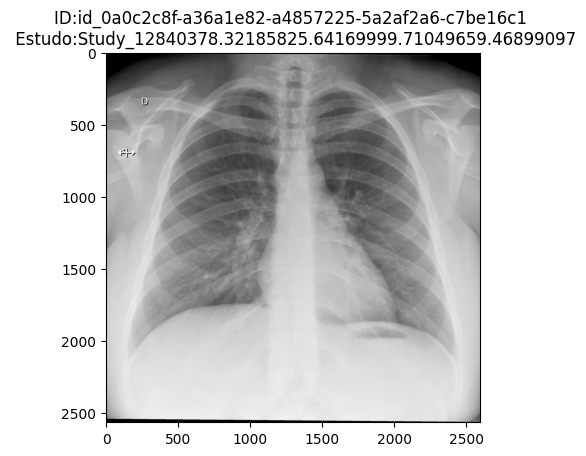

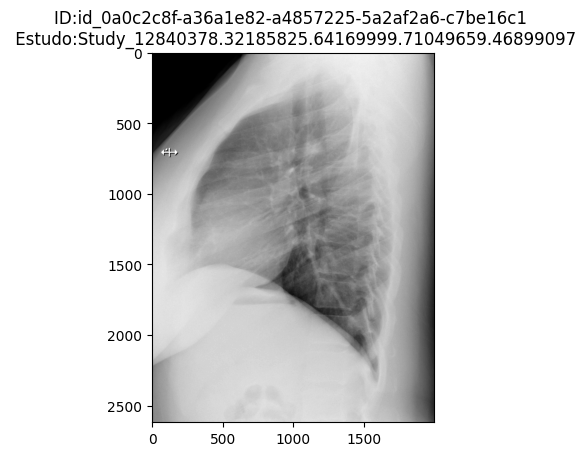

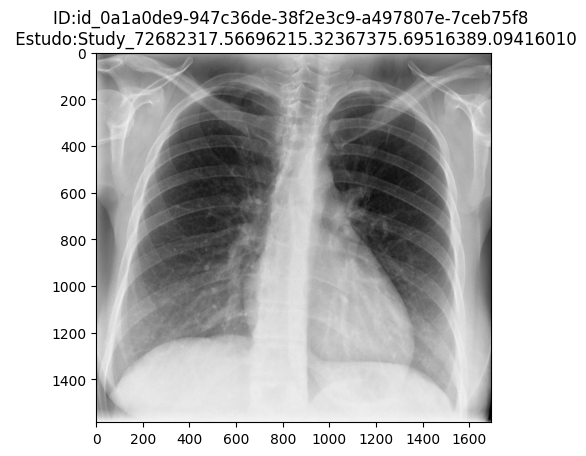

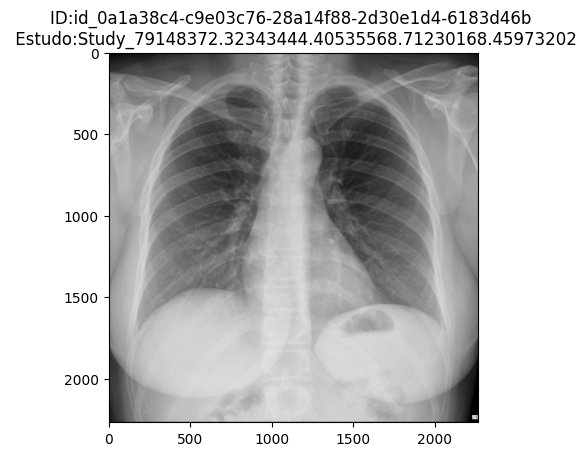

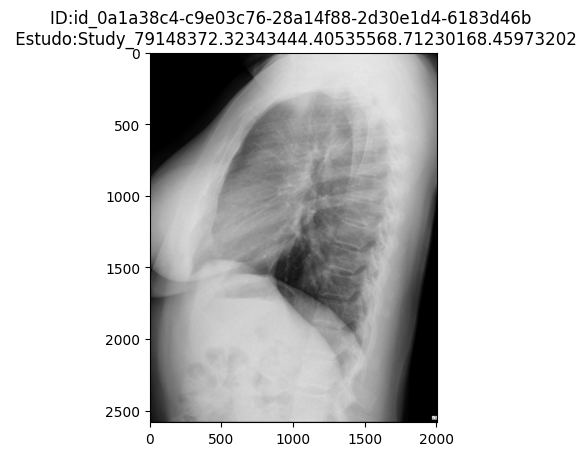

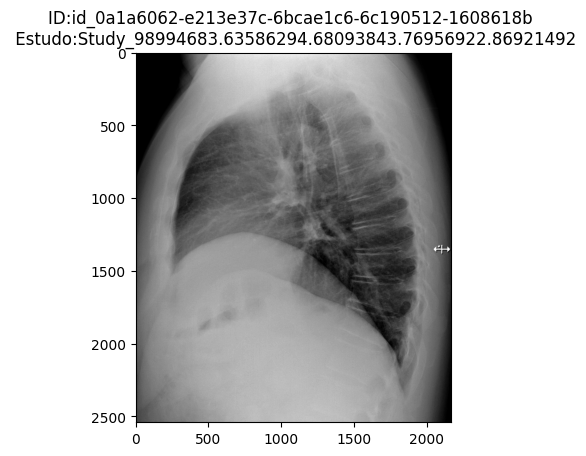

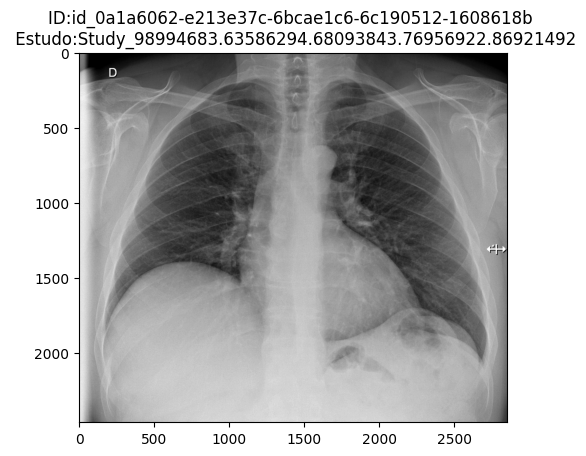

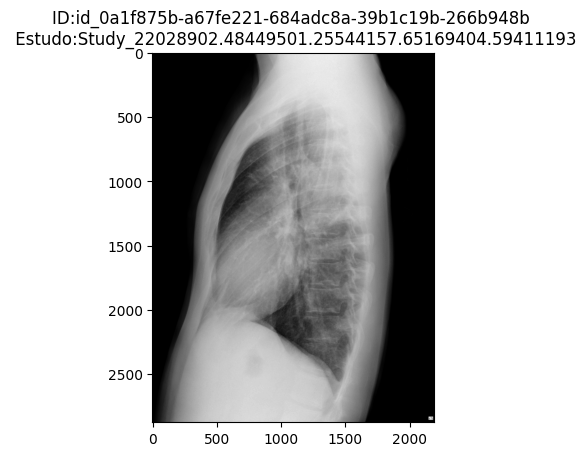

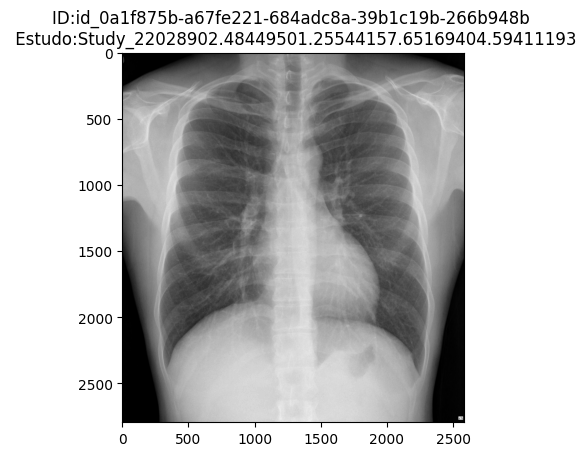

In [3]:
# plotar imagens
for file in imagens.keys():
    img = imagens[file].get("imagem")
    id = imagens[file].get("id")
    estudo = imagens[file].get("estudo")
    plt.imshow(img, cmap = 'gray')
    plt.title(f"ID:{id} \n Estudo:{estudo}")
    plt.show()

Agora irei preparar um modelo pré-treinado que existe na biblioteca TorchXRayVision.

In [4]:
# modelo
model = xrv.models.DenseNet(weights="densenet121-res224-all")

Implementando o modelo nas imagens, note que foi feito um tratamento quanto a dimensões pois o modelo não roda apenas passando a imagem "crua" lida com a função xrv.utils.read_xray_dcm()

In [5]:
# estava com problemas quanto a dimensao das imagens 
# adicionei duas dimensoes na imagem que pesquisando seria o 'batch' e 'channel'

classification = {}

# model.pathologies nos da as 18 saidas de todos os modelos xrv

for file in imagens.keys():
    imagem = imagens[file].get("imagem")
    if imagem.ndim == 2:
        imagem = imagem.unsqueeze(0).unsqueeze(0)
        print(imagem.shape)
    
    # Rodar modelo
    try:
        saidas = model(imagem)
        print(f"Saídas para {file}: {saidas} \n")
        resultado = dict(zip(model.pathologies, saidas.squeeze().tolist())) # squeeze remove qualquer dim de tamanho 1
        classification[file] = resultado

    except Exception as e:
        print(f"Erro no arquivo {file}: {e}")

torch.Size([1, 1, 2566, 2598])
Saídas para image-77089611-78785961-69826278-95000740-26294623.dcm: tensor([[0.1404, 0.0972, 0.0867, 0.2927, 0.0100, 0.0169, 0.0046, 0.0257, 0.3529,
         0.0220, 0.0070, 0.1298, 0.0448, 0.0048, 0.0033, 0.2922, 0.0873, 0.0233]],
       grad_fn=<IndexPutBackward0>) 

torch.Size([1, 1, 2619, 2000])
Saídas para image-23691574-78007127-67077450-08256882-87395367.dcm: tensor([[0.5137, 0.5309, 0.5129, 0.5000, 0.5157, 0.5018, 0.5000, 0.5594, 0.7789,
         0.1653, 0.4855, 0.5179, 0.5334, 0.0406, 0.0049, 0.4923, 0.7338, 0.5090]],
       grad_fn=<IndexPutBackward0>) 

torch.Size([1, 1, 1584, 1692])
Saídas para image-49456968-50961677-93916823-30114741-97249659.dcm: tensor([[0.1117, 0.0513, 0.1903, 0.0960, 0.0289, 0.4219, 0.1008, 0.0174, 0.4704,
         0.2054, 0.1846, 0.2358, 0.0132, 0.0028, 0.0066, 0.2011, 0.1303, 0.1289]],
       grad_fn=<IndexPutBackward0>) 

torch.Size([1, 1, 2268, 2268])
Saídas para image-75545339-55870039-51885816-92064157-98378507.dcm

A saída é um dicionario com as chaves primárias sendo os nomes das imagens e as chaves secundária sendo as doenças classificadas e seus valores preditos pelo modelo.

In [6]:
classification

{'image-77089611-78785961-69826278-95000740-26294623.dcm': {'Atelectasis': 0.14039023220539093,
  'Consolidation': 0.09720922261476517,
  'Infiltration': 0.08673122525215149,
  'Pneumothorax': 0.2926817536354065,
  'Edema': 0.0100492462515831,
  'Emphysema': 0.01690962351858616,
  'Fibrosis': 0.004595241975039244,
  'Effusion': 0.025685401633381844,
  'Pneumonia': 0.3528873324394226,
  'Pleural_Thickening': 0.021971652284264565,
  'Cardiomegaly': 0.006964836735278368,
  'Nodule': 0.12978129088878632,
  'Mass': 0.04481406882405281,
  'Hernia': 0.004847038071602583,
  'Lung Lesion': 0.0032790289260447025,
  'Fracture': 0.2921867072582245,
  'Lung Opacity': 0.08727067708969116,
  'Enlarged Cardiomediastinum': 0.02331019937992096},
 'image-23691574-78007127-67077450-08256882-87395367.dcm': {'Atelectasis': 0.5137088894844055,
  'Consolidation': 0.5308692455291748,
  'Infiltration': 0.5128545761108398,
  'Pneumothorax': 0.5000287890434265,
  'Edema': 0.5156525373458862,
  'Emphysema': 0.5018

Criando um arquivo .JSON com as saídas da classificação das imagens

In [212]:
import json

classificacao_path = dicom_file_path + "/classificação.json"

with open(classificacao_path, "w") as arquivo:
    json.dump(classification, arquivo, indent = 4)


Para cada imagem, irei escrever um arquivo JSON com a saída do modelo, em sua pasta original.

In [174]:
for img, valor in classification.items():
    for root, dirs, files in os.walk(dicom_file_path): #aqui estou pegando os caminhos do meu diretorio para enviar as imagens
        for file in files:
            if file == img:
                img = img.replace(".dcm","")
                file_path = os.path.join(root, f"{img}.json") #junta o caminho do arquivo
    
    with open(file_path, 'w') as arquivo:
        json.dump(valor, arquivo, indent = 4)
    print(f'Arquivo JSON salvo em {file_path}')
                

Arquivo JSON salvo em C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial\id_0a0c2c8f-a36a1e82-a4857225-5a2af2a6-c7be16c1\Study_12840378.32185825.64169999.71049659.46899097\Series_60731327.33236805.18319358.84233616.48423037\image-77089611-78785961-69826278-95000740-26294623.json
Arquivo JSON salvo em C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial\id_0a0c2c8f-a36a1e82-a4857225-5a2af2a6-c7be16c1\Study_12840378.32185825.64169999.71049659.46899097\Series_84360887.47369423.71070381.05368932.51324052\image-23691574-78007127-67077450-08256882-87395367.json
Arquivo JSON salvo em C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial\id_0a1a0de9-947c36de-38f2e3c9-a497807e-7ceb75f8\Study_72682317.56696215.32367375.69516389.09416010\Series_94559003.83259051.98386686.73459116.65935633\image-49456968-50961677-93916823-30114741-97249659.json
Arquivo JSON salvo em C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial\id_0a1a38c4-c9e03c76-28a14f88-2d30e1d4-6183d46b\Study_7

# Criar DICOM SR

Aqui foi desafiador até entender +- a estrutura de um DICOM SR, o chatGPT me ajudou muito com a definição de argumentos que eu não sabia se eram necessários ou não.

In [197]:
import pydicom
from pydicom.dataset import Dataset
from pydicom.uid import generate_uid, UID


def DICOM_SR(dicom_file_path, classification):
    # Carregar o DICOM original para obter informações do paciente, estudo e série
    original_dicom = pydicom.dcmread(dicom_file_path)
    
    # Criar um novo dataset para o DICOM SR
    ds = Dataset()

    # Adicionar informações de meta
    ds.file_meta = Dataset()
    ds.file_meta.MediaStorageSOPClassUID = UID('1.2.840.10008.5.1.4.1.1.88.22')  # DICOM SR SOP Class
    ds.file_meta.MediaStorageSOPInstanceUID = generate_uid()
    ds.file_meta.TransferSyntaxUID = UID('1.2.840.10008.1.2.1')  # Explicit VR Little Endian
    

    # Adicionar informações do paciente
    ds.PatientID = original_dicom.PatientID
    ds.PatientName = original_dicom.PatientName
    ds.StudyInstanceUID = original_dicom.StudyInstanceUID
    ds.SeriesInstanceUID = original_dicom.SeriesInstanceUID 
    ds.StudyDate = original_dicom.StudyDate
    ds.PatientComments = os.path.basename(dicom_file_path).replace(".dcm", "")

    # Definir o SOP Class para o DICOM SR
    ds.SOPClassUID = UID('1.2.840.10008.5.1.4.1.1.88.22')  # DICOM SR SOP Class
    ds.SOPInstanceUID = generate_uid()
    ds.Modality = 'SR'
    
    # Criar o conteúdo do DICOM SR
    ds.ContentSequence = []

    # Criar um item de conteúdo para cada chave e valor no dicionário
    for chave, valor in classification.items():
        content_item = Dataset()
        content_item.ValueType = "TEXT"
        content_item.ConceptNameCodeSequence = [Dataset()]
        content_item.ConceptNameCodeSequence[0].CodeValue = str(valor)
        content_item.ConceptNameCodeSequence[0].CodingSchemeDesignator = 'DCM'
        content_item.ConceptNameCodeSequence[0].CodeMeaning = chave
        content_item.Value = [str(valor)]
        ds.ContentSequence.append(content_item)

    # Salvar o DICOM SR em um arquivo
    sr_file_path = dicom_file_path.replace('.dcm', '_SR.dcm')
    ds.save_as(sr_file_path)
    print(f'DICOM SR salvo em {sr_file_path}')




Salvando os arquivos DICOM SR

In [198]:
for img, valor in classification.items():
    for root, dirs, files in os.walk(dicom_file_path): #aqui estou pegando os caminhos do meu diretorio para enviar as imagens
        for file in files:
            if file == img:
                file_path = os.path.join(root,file) #junta o caminho do arquivo

                DICOM_SR(file_path, classification[f"{img}"])


    

DICOM SR salvo em C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial\id_0a0c2c8f-a36a1e82-a4857225-5a2af2a6-c7be16c1\Study_12840378.32185825.64169999.71049659.46899097\Series_60731327.33236805.18319358.84233616.48423037\image-77089611-78785961-69826278-95000740-26294623_SR.dcm
DICOM SR salvo em C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial\id_0a0c2c8f-a36a1e82-a4857225-5a2af2a6-c7be16c1\Study_12840378.32185825.64169999.71049659.46899097\Series_84360887.47369423.71070381.05368932.51324052\image-23691574-78007127-67077450-08256882-87395367_SR.dcm
DICOM SR salvo em C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial\id_0a1a0de9-947c36de-38f2e3c9-a497807e-7ceb75f8\Study_72682317.56696215.32367375.69516389.09416010\Series_94559003.83259051.98386686.73459116.65935633\image-49456968-50961677-93916823-30114741-97249659_SR.dcm
DICOM SR salvo em C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial\id_0a1a38c4-c9e03c76-28a14f88-2d30e1d4-6183d46b\Study_79148372.32

In [165]:


print("Informações básicas do DICOM SR:")
print(f"Patient Name: {ds.PatientName}")
print(f"Patient ID: {ds.PatientID}")
print(f"Patient Study: {ds.StudyInstanceUID}")
print(f"Patient Series: {ds.SeriesInstanceUID}")
print(f"Imagem : {ds.PatientComments}")

# Exemplo de como acessar o conteúdo do Structured Report
if 'ContentSequence' in ds:
    for item in ds.Classificacao:
        print(item.items())
        # Verifique o tipo de valor e exiba informações
        print(f"Item Value Type: {item.ValueType}")
        print(f"Item Value: {item}")






Informações básicas do DICOM SR:
Patient Name: id_0a1a0de9-947c36de-38f2e3c9-a497807e-7ceb75f8
Patient ID: id_0a1a0de9-947c36de-38f2e3c9-a497807e-7ceb75f8
Patient Study: 72682317.56696215.32367375.69516389.09416010
Patient Series: 94559003.83259051.98386686.73459116.65935633
Imagem : image-49456968-50961677-93916823-30114741-97249659


AttributeError: 'FileDataset' object has no attribute 'Classificacao'

# Enviando DICOM_SR para a PACS OrthanC

In [200]:
import requests

# configurações
orthanc_url = 'http://localhost:80'
dicom_file_path = 'C:/Users/tiago/OneDrive/UNICAMP/IC Inteligência Artificial'
username = 'demo'
password = 'demo'


# função para enviar um arquivo DICOM SR para o OrthanC
def enviar_SR(dicom_file_path):
    # Abrir o arquivo DICOM SR
    with open(dicom_file_path, 'rb') as f:
        dicom_data = f.read()
    
    # Enviar o arquivo DICOM SR para o Orthanc PACS
    response = requests.post(
        f'{orthanc_url}/instances',
        files={'file': dicom_data},
        auth=(username, password)
    )
    


# função para andar pelos diretorios e achar as imagens
def caminho(diretorio):
    for root, dirs, files in os.walk(diretorio): #aqui estou pegando os caminhos do meu diretorio para enviar as imagens
        for file in files:
            if file.endswith("_SR.dcm"):
                file_path = os.path.join(root, file) #junta o caminho do arquivo
                enviar_SR(file_path) #envia o arquivo para a API
                print('arquivo enviado')

# Enviar o arquivo DICOM
caminho(dicom_file_path)

arquivo enviado
arquivo enviado
arquivo enviado
arquivo enviado
arquivo enviado
arquivo enviado
arquivo enviado
arquivo enviado
arquivo enviado


Arquivos DICOM SR enviados devidamente para suas respectivas imagens
